<a href="https://colab.research.google.com/github/vjsurampudi/LeafDiseaseClassification_CICD/blob/main/LeafDisease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Rebuilt for learning purpose from: https://www.youtube.com/watch?v=uKXuCLoXT_s

Business Problem - Farmers have to personally go to the farm and inspect if the plants are infected or healthy. Imagery of the leaves from a drone can help assess the health of the plants and the extent of infection in the farm. 
Objective is to train a model using transfer learning techniques that can classify a healthy plant leaf from an infected plant leaf. Dataset of images from Kaggle is used for training the model.\

Approach for solution development

1.   Training an image classifier model
2.   Creating Streamlit Application
3.   Create automated build script
4.   Manual trigger of Build into K8s
5.   Automated CI/CD pipeline

In [1]:
import tensorflow as tf
from IPython.display import Image, display 

import matplotlib.pyplot as plt
import tensorflow_hub as hub
import numpy as np
import warnings

warnings.filterwarnings('ignore')

In [3]:
!nvidia-smi

Sun Dec 19 10:21:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Loading Dataset

Dataset can be loaded from tensorflow dataset as well. But here, we are loading it from external files. The dataset is also available at Kaggle. 

In [4]:
!wget https://storage.googleapis.com/ibeans/train.zip
!wget https://storage.googleapis.com/ibeans/validation.zip
!wget https://storage.googleapis.com/ibeans/test.zip

--2021-12-19 10:21:47--  https://storage.googleapis.com/ibeans/train.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 74.125.140.128, 108.177.15.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143812152 (137M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>] 137.15M  53.1MB/s    in 2.6s    

2021-12-19 10:21:51 (53.1 MB/s) - ‘train.zip’ saved [143812152/143812152]

--2021-12-19 10:21:51--  https://storage.googleapis.com/ibeans/validation.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 66.102.1.128, 142.251.5.128, 74.125.133.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|66.102.1.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18504213 (18M) [application/zip]
Saving to: ‘validation.zip’

validation.zip      100%[===================>]  1

In [5]:
!mkdir beans

In [6]:
!unzip train.zip -d beans
!unzip validation.zip -d beans
!unzip test.zip -d beans

Archive:  train.zip
   creating: beans/train/
   creating: beans/train/healthy/
   creating: beans/train/angular_leaf_spot/
   creating: beans/train/bean_rust/
  inflating: beans/train/healthy/healthy_train.265.jpg  
  inflating: beans/train/healthy/healthy_train.271.jpg  
  inflating: beans/train/healthy/healthy_train.259.jpg  
  inflating: beans/train/healthy/healthy_train.99.jpg  
  inflating: beans/train/healthy/healthy_train.311.jpg  
  inflating: beans/train/healthy/healthy_train.66.jpg  
  inflating: beans/train/healthy/healthy_train.72.jpg  
  inflating: beans/train/healthy/healthy_train.305.jpg  
  inflating: beans/train/healthy/healthy_train.339.jpg  
  inflating: beans/train/healthy/healthy_train.113.jpg  
  inflating: beans/train/healthy/healthy_train.107.jpg  
  inflating: beans/train/healthy/healthy_train.106.jpg  
  inflating: beans/train/healthy/healthy_train.112.jpg  
  inflating: beans/train/healthy/healthy_train.338.jpg  
  inflating: beans/train/healthy/healthy_trai

In [7]:
!ls beans

test  train  validation


In [8]:
!ls beans/train

angular_leaf_spot  bean_rust  healthy


In [9]:
## Counting the total number of files in the "beans" folder
!find beans -type f | wc -l

1296


In [10]:
## Counting the total number of files in the "beans/test" folder
!find beans/test -type f | wc -l

128


In [12]:
## Counting the total number of files in the "beans/validation" folder
!find beans/validation -type f | wc -l

133


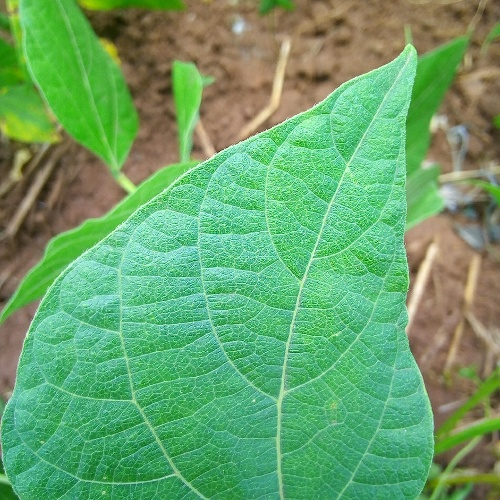

In [13]:
display(Image('beans/train/healthy/healthy_train.0.jpg'))

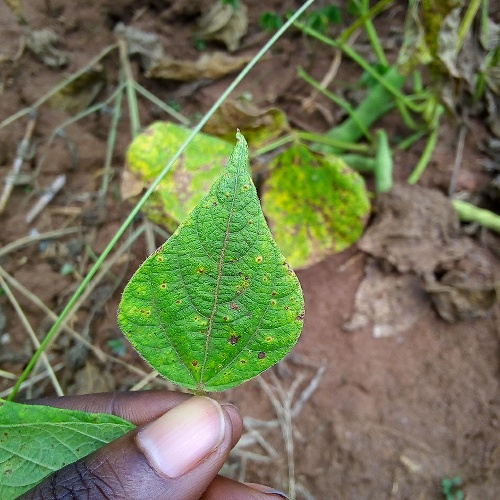

In [14]:
display(Image('beans/train/bean_rust/bean_rust_train.162.jpg'))

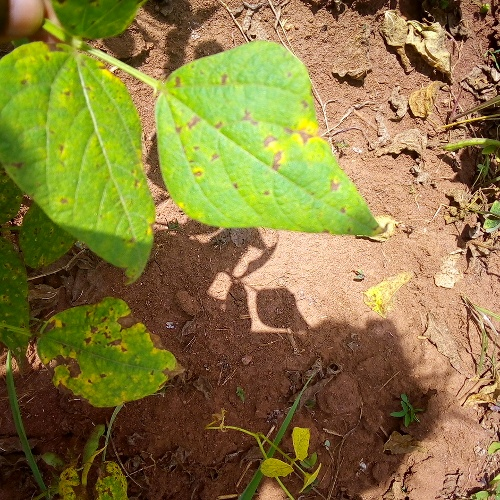

In [15]:
display(Image('beans/train/angular_leaf_spot/angular_leaf_spot_train.0.jpg'))

The directory structure is important if we are using Keras image_dataset_from_directory function. For example, see the folder structure below:

main_directory/
...class_a/
......a_image_1.jpg
......a_image_2.jpg
...class_b/
......b_image_1.jpg
......b_image_2.jpg

using Keras.image_dataset_from_directory function will return a tf.Data.Dataset that yields a batch of images from the subdirectories class_a and class_b, together with labels 0 and 1 (0 corresponding to class_a and 1 corresponding to class_b) 

Documentation: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In the dataset, the number of images is neither too low nor too high. So, we can use either:
1. Build a custom CNN model
2. Use transfer learning model 
3. Fine tuning of existing architecture

For this solution, I will go with option#3, to use existing imagenet model. Hence the image size should match the architecture of model being used. So setting the img_height and img_width = 224



In [21]:
batch_size = 128
img_height = 224
img_width = 224

In [22]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory('beans/train',
                                                               seed=111,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size)

Found 1034 files belonging to 3 classes.


In [23]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory('beans/test',
                                                               seed=111,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size)

Found 128 files belonging to 3 classes.


In [24]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory('beans/validation',
                                                               seed=111,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size)

Found 133 files belonging to 3 classes.


In [25]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 224, 224, 3)
(128,)


In [26]:
classes=train_ds.class_names
print(classes)

['angular_leaf_spot', 'bean_rust', 'healthy']


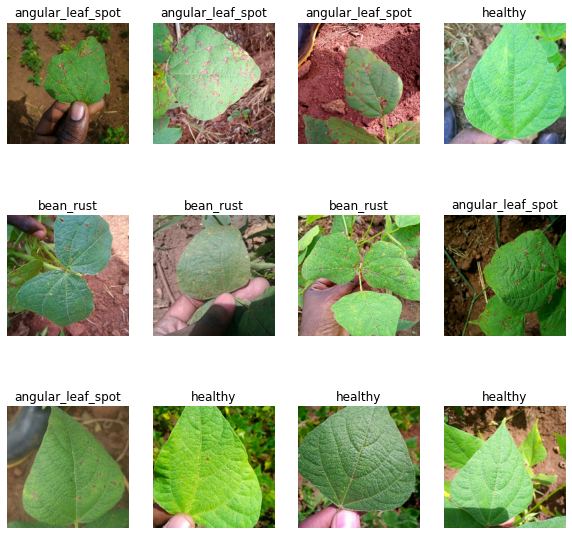

In [32]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3,4, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

Prefetch overlaps the preprocessing and model execution of a training step. While the model is executing training step s, the input pipeline is reading the data for step s+1. Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data.

The tf.data API provides the tf.data.Dataset.prefetch transformation. It can be used to decouple the time when data is produced from the time when data is consumed. In particular, the transformation uses a background thread and an internal buffer to prefetch elements from the input dataset ahead of the time they are requested. The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step. You could either manually tune this value, or set it to tf.data.AUTOTUNE, which will prompt the tf.data runtime to tune the value dynamically at runtime.

It is important to optimize input and training while GPU is being used

https://www.tensorflow.org/guide/data_performance

In [33]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

[TensorFlow Hub for pretrained models](https://tfhub.dev/)

Image Problems -> Feature vector and classification. Feature Vectors contains trained instances of models to get the feature vectors (last layer). In this example, we use feature vectors. Sample code and details [Mobile V-Net feature Vectors](https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4)

In [34]:
feature_extractor= "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [35]:
feature_extractor_layer = hub.KerasLayer(feature_extractor, input_shape=(img_height,img_width,3))

If the data is completely different from data used in pretrained model, if you want to tune all the layers to use only architecture and build the model, then set trainable=True. In the current example, the classification is only classification across different types of same object - Leaf.

In [36]:
feature_extractor_layer.trainable=False ## Do not finetune the model

In [42]:
normalization_layer = tf.keras.layers.Rescaling(1./255) ## Use layers so that it gets included in the preprocessing pipeline

In [47]:
tf.random.set_seed(111)

In [44]:
model = tf.keras.Sequential([normalization_layer,
                             feature_extractor_layer,
                             tf.keras.layers.Dropout(0.3), ## to avoid overfitting
                             tf.keras.layers.Dense(3, activation='softmax')])

In [46]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), ## Since target is not one-hot encoded, sparsecategoricalentropy is being used
    metrics=['accuracy'])

In [48]:
history = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
9/9 [==============================] - 21s 527ms/step - loss: 1.1233 - accuracy: 0.4536 - val_loss: 0.7627 - val_accuracy: 0.7068
Epoch 2/20
9/9 [==============================] - 3s 293ms/step - loss: 0.7876 - accuracy: 0.6373 - val_loss: 0.6004 - val_accuracy: 0.7669
Epoch 3/20
9/9 [==============================] - 3s 289ms/step - loss: 0.6398 - accuracy: 0.7427 - val_loss: 0.5156 - val_accuracy: 0.7669
Epoch 4/20
9/9 [==============================] - 3s 303ms/step - loss: 0.5832 - accuracy: 0.7485 - val_loss: 0.4663 - val_accuracy: 0.7970
Epoch 5/20
9/9 [==============================] - 3s 305ms/step - loss: 0.4954 - accuracy: 0.7959 - val_loss: 0.4307 - val_accuracy: 0.8045
Epoch 6/20
9/9 [==============================] - 3s 311ms/step - loss: 0.4806 - accuracy: 0.7959 - val_loss: 0.4027 - val_accuracy: 0.8120
Epoch 7/20
9/9 [==============================] - 3s 288ms/step - loss: 0.4484 - accuracy: 0.8211 - val_loss: 0.3817 - val_accuracy: 0.8647
Epoch 8/20
9/9 [===

In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


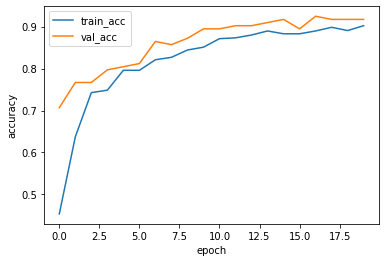

In [49]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc','val_acc'], loc='best')
plt.show()

In [51]:
result = model.evaluate(test_ds)

1/1 [==============================] - 1s 739ms/step - loss: 0.2984 - accuracy: 0.8594


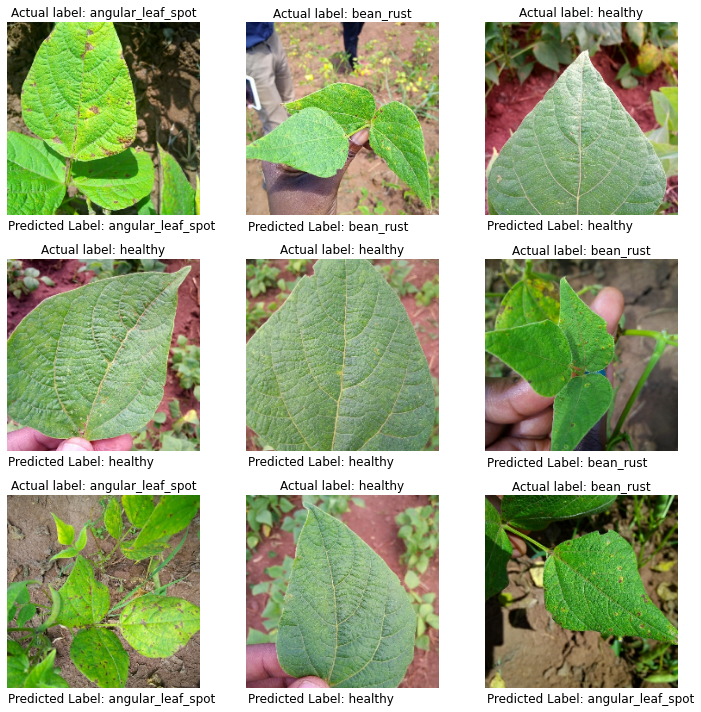

In [53]:
plt.figure(figsize=(10,10))
for images,labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.tight_layout()
    img = tf.keras.preprocessing.image.img_to_array(images[i])
    img = np.expand_dims(img,axis=0)
    pred = model.predict(img)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("Actual label: %s" %classes[labels[i]])
    plt.text(1,240, "Predicted Label: %s" % classes[np.argmax(pred)], fontsize=12)
    plt.axis("off")

In [59]:
model.save('./models',save_format='tf') ## tf is latest format. h5 is old format

INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


In [58]:
!ls -alrt models

total 1880
drwxr-xr-x 1 root root    4096 Dec 19 11:41 ..
drwxr-xr-x 2 root root    4096 Dec 19 11:41 variables
drwxr-xr-x 2 root root    4096 Dec 19 11:41 assets
-rw-r--r-- 1 root root 1897836 Dec 19 11:41 saved_model.pb
-rw-r--r-- 1 root root    6885 Dec 19 11:41 keras_metadata.pb
drwxr-xr-x 4 root root    4096 Dec 19 11:41 .


In [56]:
model_loaded = tf.keras.models.load_model('./models/')

In [57]:
model_loaded.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________
